In [31]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from utils import load_data
from utils import normalization, renormalization
from utils import introduce_missing_data

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import ExtraTreesRegressor

from GAIN.gain import gain
from knnxkde import KNNxKDE
from softimpute.softimpute import softimpute

# Presentation of the three synthetic data sets

In [32]:
LIST_DATASETS = [
    '2d_linear',
    '2d_sine',
    '2d_ring',
]

LIST_TICKS = [
    [[0.0, 0.5, 1.0], [0.0, 0.5, 1.0]],
    [[0, 5, 10], [-1, 0, 1]],
    [[-1, 0, 1], [-1, 0, 1]],
]

In [33]:
x1_linear = np.linspace(start=0.0, stop=1.0, num=200)
x2_linear = x1_linear
x1_sine = np.linspace(start=0.0, stop=4.0*np.pi, num=200)
x2_sine = np.sin(x1_sine)
theta_ring = np.linspace(start=0.0, stop=2.0*np.pi, num=200)
x1_ring = np.cos(theta_ring)
x2_ring = np.sin(theta_ring)

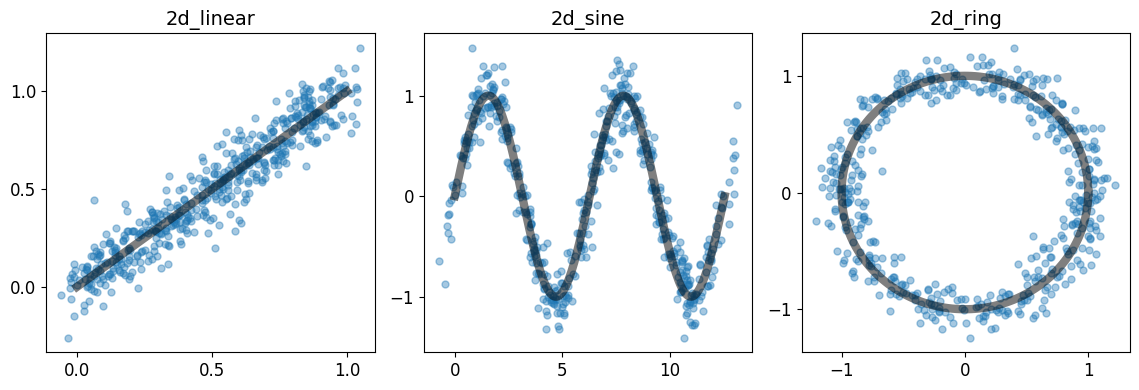

In [34]:
fig, ax = plt.subplots(1, 3, figsize=(11.5, 4))

for i in range(len(LIST_DATASETS)):
    cur_name = LIST_DATASETS[i]
    original_data = load_data(cur_name)
    ax[i].scatter(original_data[:, 0], original_data[:, 1], s=25, alpha=0.4)
    ax[i].set_xticks(LIST_TICKS[i][0])
    ax[i].set_yticks(LIST_TICKS[i][1])
    ax[i].tick_params(axis='both', labelsize=12)
    ax[i].set_title(cur_name, size=14)

ax[0].plot(x1_linear, x2_linear, c='black', alpha=0.5, lw=6)
ax[1].plot(x1_sine, x2_sine, c='black', alpha=0.5, lw=6)
ax[2].plot(x1_ring, x2_ring, c='black', alpha=0.5, lw=6)

plt.tight_layout()
plt.savefig('figures/synthetic_datasets.pdf')
plt.show()

# Presentation of three synthetic data sets

Note :
- The hyper-parameters are set to the value that best minimizes the NRMSE in `full_mcar` scenario with 20% missing rate. These values can be accessed in the `output/full_mcar/rmse` folder, by looking at the corresponding datasets.

/!\ Warning /!\
- Setting `BEST_NB_NEIGHBORS = [1, 1, 1]` or `BEST_NB_TREES = [1, 1, 1]` leads to visually satisfying results, but keep in mind that $k$NN-Imputer with $k=1$ and MissForest with 1 regression tree lead to poor imputation as one mode has been chosen and we have no guarantee to assess whether this corresponds to the ground truth.
- See extensive discussion here: https://openreview.net/forum?id=KqR3rgooXb&referrer=%5BTMLR%5D(%2Fgroup%3Fid%3DTMLR)

In [35]:
LIST_DATASETS = [
    '2d_linear',
    '2d_sine',
    '2d_ring',
]

LIST_TICKS = [
    [[0.0, 0.5, 1.0], [0.0, 0.5, 1.0]],
    [[0, 5, 10], [-1, 0, 1]],
    [[-1, 0, 1], [-1, 0, 1]],
]

MISS_RATE = 0.2

BEST_NB_NEIGHBORS = [20, 20, 100]
BEST_NB_TREES = [10, 20, 20]
BEST_NB_ITERS = [2000, 200, 200]
BEST_LAMBDAS = [1.0, 5.0, 5.0]

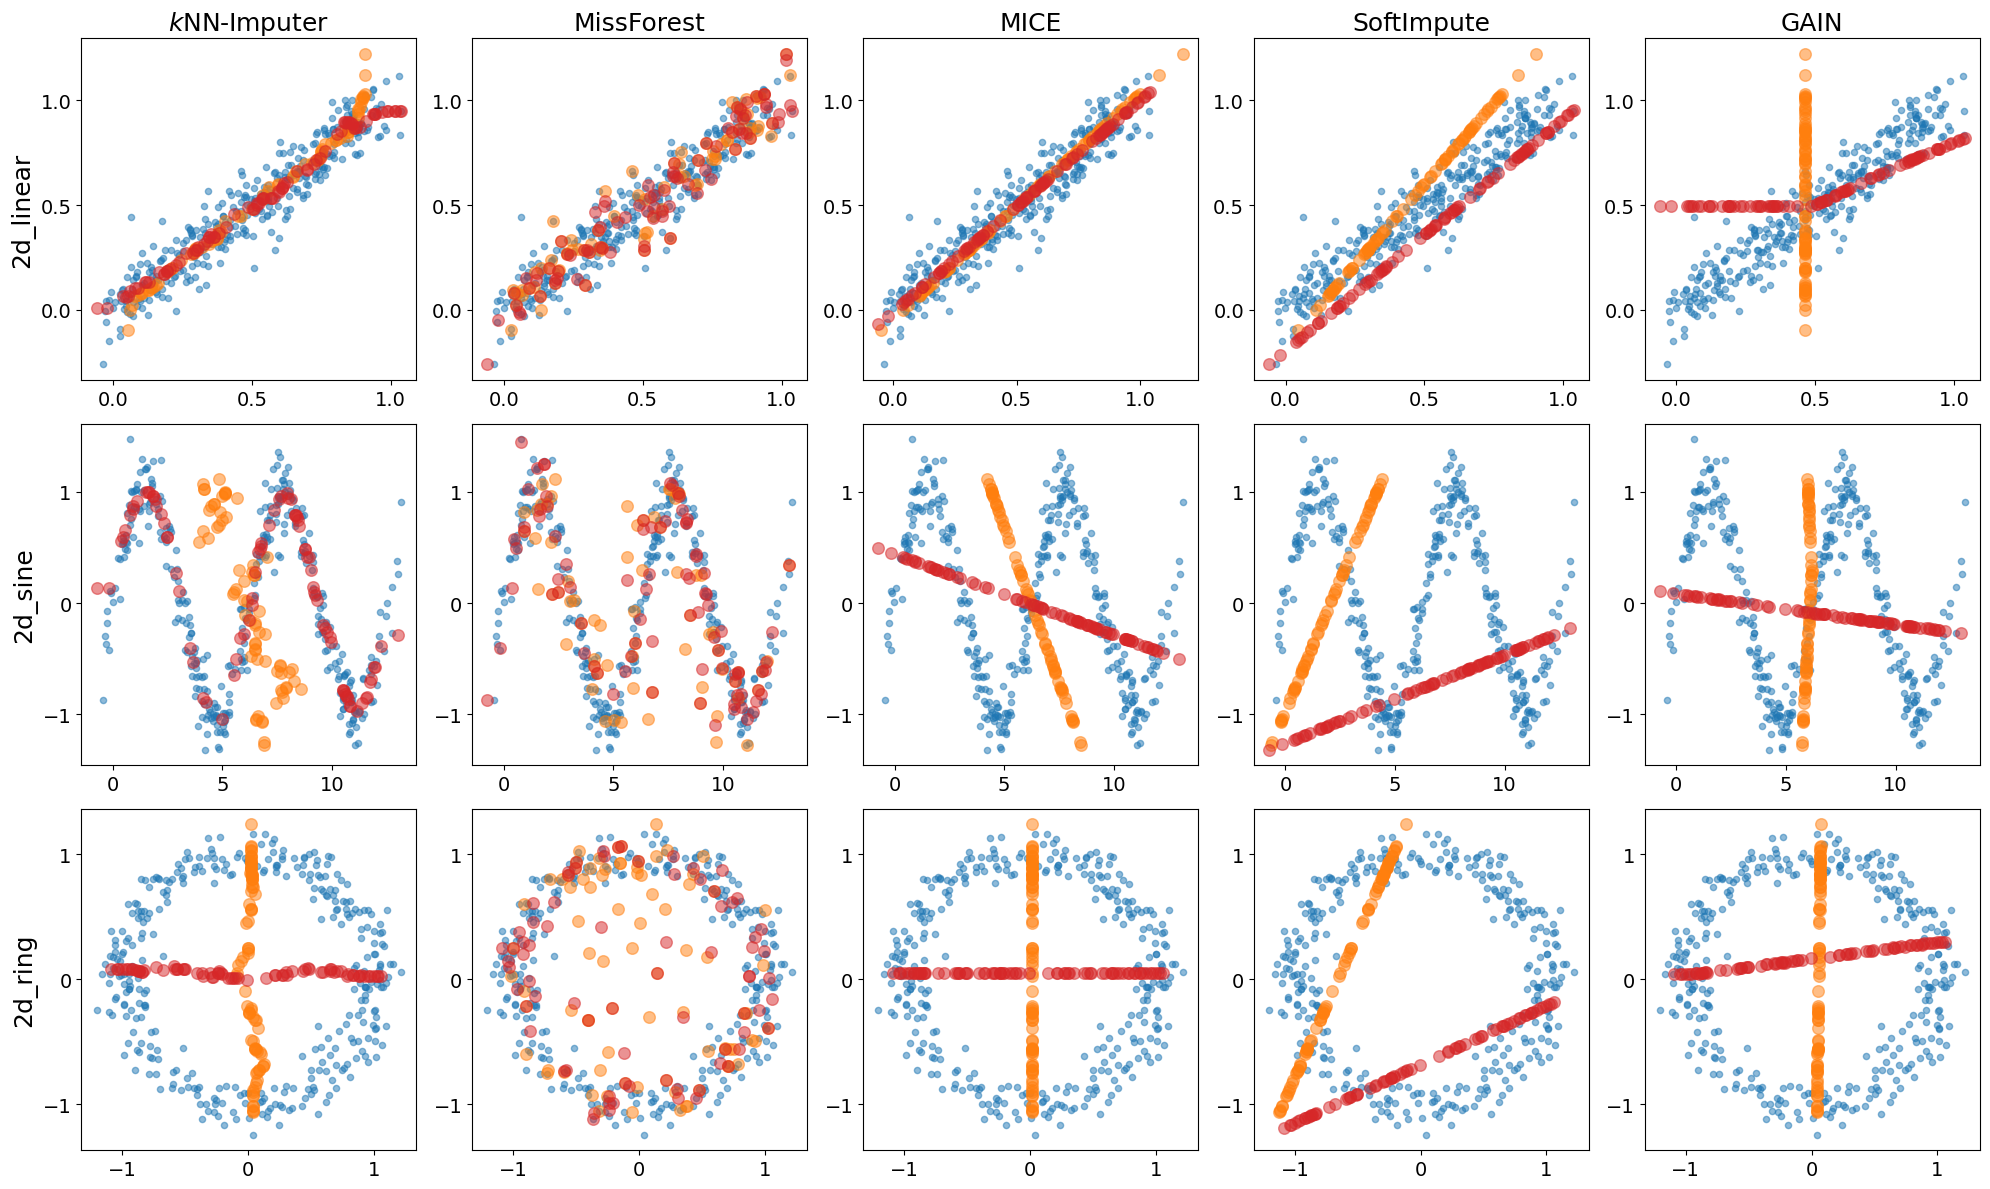

In [36]:
fig, ax = plt.subplots(3, 5, figsize=(20, 12))

for i1 in range(3):
    cur_data_name = LIST_DATASETS[i1]
    original_data = load_data(cur_data_name)
    miss_data = introduce_missing_data(
        original_data=original_data,
        miss_rate=MISS_RATE,
        mode='full_mcar',
        data_name=cur_data_name,
    )
    norm_miss_data, norm_params = normalization(miss_data)
    
    for i2 in range(5):
        print(i1, i2, end='\r', flush=True)
        if i2==0:  # kNN-Imputer
            cur_nb_neigh = BEST_NB_NEIGHBORS[i1]
            imputer = KNNImputer(n_neighbors=cur_nb_neigh)  # optimal number of neighbours
            norm_imputed_data = imputer.fit_transform(norm_miss_data)
        elif i2==1:  # MissForest
            cur_nb_trees = BEST_NB_TREES[i1]
            estimator = ExtraTreesRegressor(n_estimators=cur_nb_trees)  # optimal number of trees
            imputer = IterativeImputer(estimator=estimator, max_iter=10, tol=1e-1, verbose=0)
            norm_imputed_data = imputer.fit_transform(norm_miss_data)
        elif i2==2:  # MICE
            estimator = BayesianRidge()  # no hyperparameter here
            imputer = IterativeImputer(estimator=estimator, max_iter=10, tol=1e-1, verbose=0)
            norm_imputed_data = imputer.fit_transform(norm_miss_data)
        elif i2==3:
            cur_lambda = BEST_LAMBDAS[i1]
            norm_imputed_data = softimpute(norm_miss_data, cur_lambda)[1]
        elif i2==4:  # GAIN
            cur_nb_iters = BEST_NB_ITERS[i1]
            gain_parameters = {'batch_size': 128, 'hint_rate': 0.9, 'alpha': 100, 'iterations': cur_nb_iters}
            norm_imputed_data = gain(norm_miss_data, gain_parameters)
        
        renorm_imputed_data = renormalization(norm_imputed_data, norm_params)
        mask_miss_x1 = np.isnan(miss_data[:, 0])
        mask_miss_x2 = np.isnan(miss_data[:, 1])
        mask_full = ~(mask_miss_x1 | mask_miss_x2)
        ax[i1, i2].scatter(
            renorm_imputed_data[mask_full, 0],
            renorm_imputed_data[mask_full, 1],
            s=20, alpha=0.5, color='C0',
        )
        ax[i1, i2].scatter(
            renorm_imputed_data[mask_miss_x1, 0],
            renorm_imputed_data[mask_miss_x1, 1],
            s=70, alpha=0.5, color='C1',
        )
        ax[i1, i2].scatter(
            renorm_imputed_data[mask_miss_x2, 0],
            renorm_imputed_data[mask_miss_x2, 1],
            s=70, alpha=0.5, color='C3',
        )
        ax[i1, i2].set_xticks(LIST_TICKS[i1][0])
        ax[i1, i2].set_yticks(LIST_TICKS[i1][1])
        ax[i1, i2].tick_params(axis='both', labelsize=14)

    ax[i1, 0].set_ylabel(cur_data_name, size=18)

ax[0, 0].set_title('$k$NN-Imputer', size=18)
ax[0, 1].set_title('MissForest', size=18)
ax[0, 2].set_title('MICE', size=18)
ax[0, 3].set_title('SoftImpute', size=18)
ax[0, 4].set_title('GAIN', size=18)

plt.tight_layout()
plt.savefig('figures/other_methods_synth_data.pdf')
plt.show()

# Imputation results for the 3 synthetic data sets

In [37]:
def scatter_kNNxKDE_results(ax, renorm_miss_data, renorm_samples):
    """DOC TODO
    """
    sub_sample_size = 10
    (n, d) = renorm_miss_data.shape
    nb_draws = 10000
    first_blue = True
    first_orange = True
    first_red = True
    for i in range(n):
        if not np.isnan(renorm_miss_data[i]).any():
            if first_blue:
                ax.scatter(renorm_miss_data[i, 0], renorm_miss_data[i, 1], s=30, alpha=0.5, color="C0", label="Complete")
                first_blue = False
            else:
                ax.scatter(renorm_miss_data[i, 0], renorm_miss_data[i, 1], s=30, alpha=0.5, color="C0")
        elif np.isnan(renorm_miss_data[i])[0]:
            r = np.random.randint(low=0, high=nb_draws, size=sub_sample_size)
            cur_sample = renorm_samples[(i, 0)][r]
            temp_data = np.zeros((sub_sample_size, 2))
            temp_data[:, 0] = cur_sample
            temp_data[:, 1] = renorm_miss_data[i, 1]
            if first_orange:
                ax.scatter(temp_data[:, 0], temp_data[:, 1], s=10, alpha=0.25, color="C1", label="Miss $x_1$")
                first_orange = False
            else:
                ax.scatter(temp_data[:, 0], temp_data[:, 1], s=10, alpha=0.25, color="C1")
        elif np.isnan(renorm_miss_data[i])[1]:
            r = np.random.randint(low=0, high=nb_draws, size=sub_sample_size)
            cur_sample = renorm_samples[(i, 1)][r]
            temp_data = np.zeros((sub_sample_size, 2))
            temp_data[:, 0] = renorm_miss_data[i, 0]
            temp_data[:, 1] = cur_sample
            if first_red:
                ax.scatter(temp_data[:, 0], temp_data[:, 1], s=10, alpha=0.25, color="C3", label="Miss $x_2$")
                first_red = False
            else:
                ax.scatter(temp_data[:, 0], temp_data[:, 1], s=10, alpha=0.25, color="C3")
        

In [38]:
LIST_DATASETS = [
    '2d_linear',
    '2d_sine',
    '2d_ring',
]

MISS_RATE = 0.2
N_SS = 10  # nb sub-samples for plotting purposes

np.random.seed(666)
FIXED_MISS_MASK = np.zeros((500, 2), dtype=bool)  # I keep a fixed MISS_MASK for demonstration
for n in range(500):
    current_mask = np.random.uniform(low=0.0, high=1.0, size=2) < MISS_RATE
    while np.logical_and.reduce(current_mask):
        current_mask = np.random.uniform(low=0.0, high=1.0, size=2) < MISS_RATE
    FIXED_MISS_MASK[n] = current_mask

CHOSEN_KEYS = [[(19, 0), (2, 1)], [(4, 0), (2, 1)], [(20, 0), (3, 1)]]  # used for plots (with seed 666)

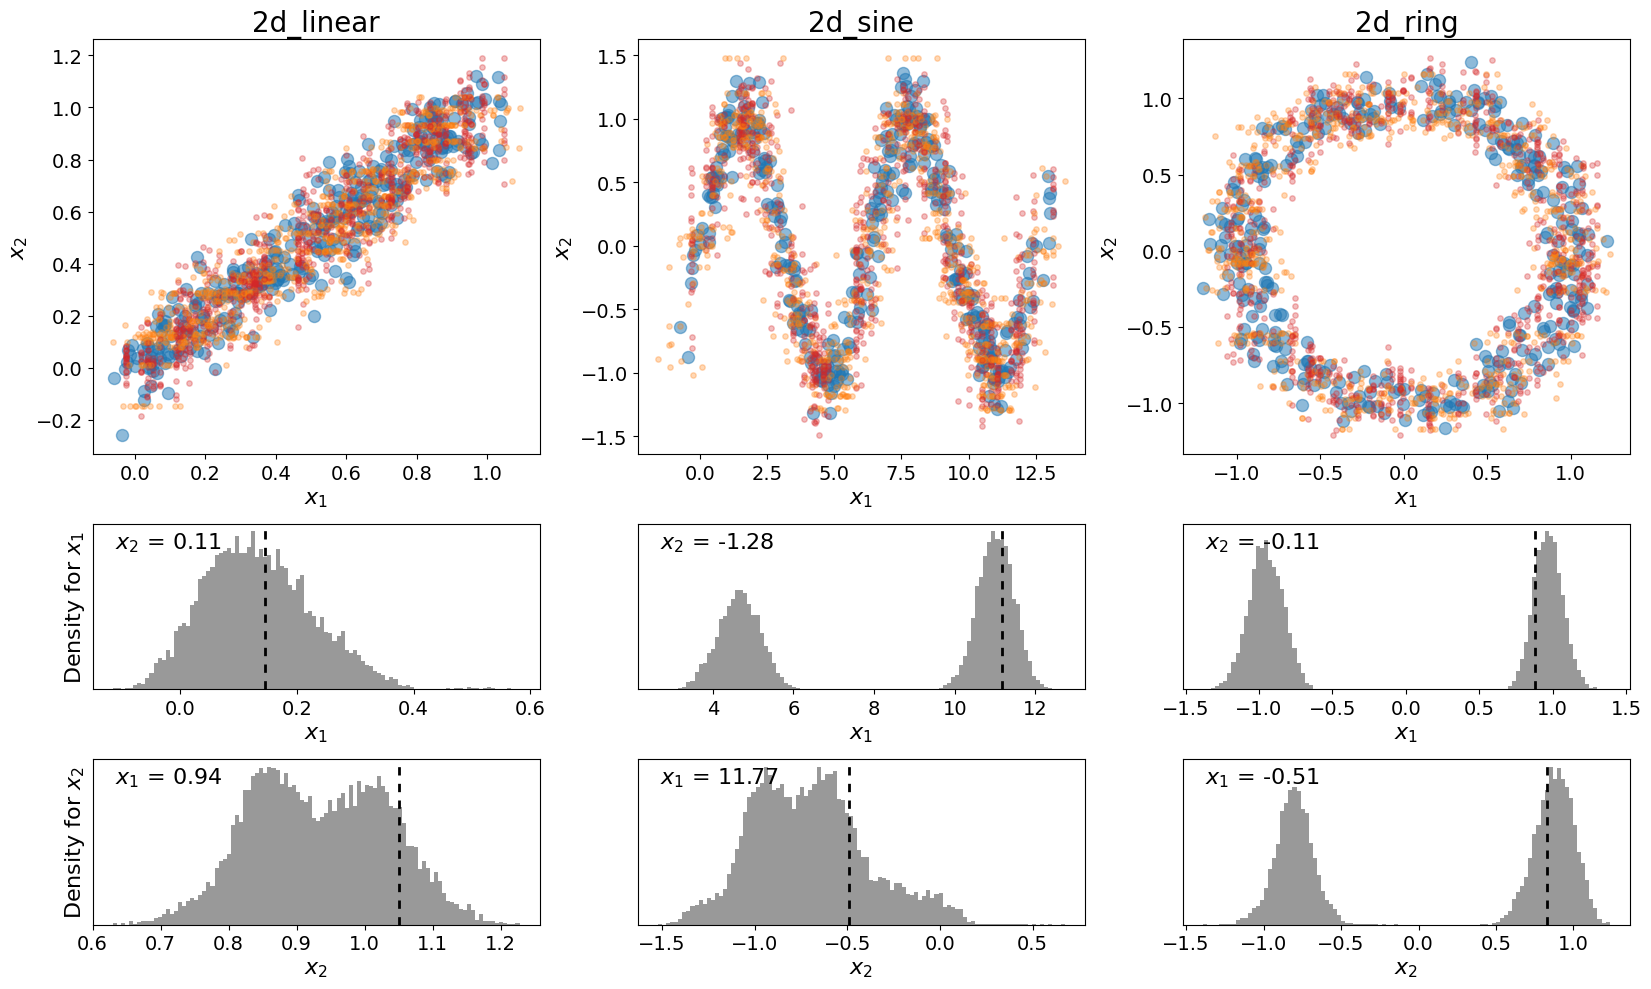

In [39]:
fig, ax = plt.subplots(3, 3, figsize=(16.5, 10), gridspec_kw={'height_ratios': [5, 2, 2]})

for i0 in range(3):
    cur_data_name = LIST_DATASETS[i0]
    original_data = load_data(cur_data_name)
    N, D = original_data.shape
    miss_data = np.copy(original_data)
    miss_data[FIXED_MISS_MASK] = np.nan
    norm_miss_data, norm_params = normalization(miss_data)
    
    knnxkde = KNNxKDE(h=0.03, tau=1.0/300.0, metric='nan_std_eucl')
    norm_imputed_samples = knnxkde.impute_samples(norm_miss_data, nb_draws=10000)
    
    ax[0, i0].scatter(miss_data[:, 0], miss_data[:, 1], s=75, alpha=0.5, color='C0')
    for i1 in range(N):
        if np.isnan(miss_data[i1, 0]):
            cur_sample = np.random.choice(norm_imputed_samples[(i1, 0)], size=N_SS, replace=False)
            m1 = norm_params['min_val'][0]
            m2 = norm_params['max_val'][0]
            cur_sample = cur_sample * (m2 + 1e-6) + m1
            y_scatter = [miss_data[i1, 1]] * N_SS
            ax[0, i0].scatter(cur_sample, y_scatter, s=15, alpha=0.3, c='C1')
        if np.isnan(miss_data[i1, 1]):
            cur_sample = np.random.choice(norm_imputed_samples[(i1, 1)], size=N_SS, replace=False)
            m1 = norm_params['min_val'][1]
            m2 = norm_params['max_val'][1]
            cur_sample = cur_sample * (m2 + 1e-6) + m1
            x_scatter = [miss_data[i1, 0]] * N_SS
            ax[0, i0].scatter(x_scatter, cur_sample, s=15, alpha=0.3, c='C3')
    ax[0, i0].set_xlabel('$x_1$', size=16)
    ax[0, i0].set_ylabel('$x_2$', size=16)
    ax[0, i0].tick_params(labelsize=14)
    
    m1 = norm_params['min_val'][0]
    m2 = norm_params['max_val'][0]
    renorm_sample = norm_imputed_samples[CHOSEN_KEYS[i0][0]] * (m2 + 1e-6) + m1
    ax[1, i0].hist(renorm_sample, bins=100, density=True, alpha=0.4, color='black')
    (x_m1, x_m2) = ax[1, i0].get_xlim()
    (y_m1, y_m2) = ax[1, i0].get_ylim()
    x_loc = x_m1 + (x_m2 - x_m1) * 0.05
    y_loc = y_m1 + (y_m2 - y_m1) * 0.85
    true_x1 = original_data[CHOSEN_KEYS[i0][0][0], 0]
    observed_x2 = original_data[CHOSEN_KEYS[i0][0][0], 1]
    txt = f'$x_2$ = {observed_x2:.2f}'
    ax[1, i0].text(x=x_loc, y=y_loc, s=txt, size=16)
    ax[1, i0].axvline(true_x1, ls=(0, (3, 3)), c='black', lw=2)
    ax[1, i0].tick_params(labelsize=14)

    m1 = norm_params['min_val'][1]
    m2 = norm_params['max_val'][1]
    renorm_sample = norm_imputed_samples[CHOSEN_KEYS[i0][1]] * (m2 + 1e-6) + m1
    ax[2, i0].hist(renorm_sample, bins=100, density=True, alpha=0.4, color='black')
    (x_m1, x_m2) = ax[2, i0].get_xlim()
    (y_m1, y_m2) = ax[2, i0].get_ylim()
    x_loc = x_m1 + (x_m2 - x_m1) * 0.05
    y_loc = y_m1 + (y_m2 - y_m1) * 0.85
    true_x2 = original_data[CHOSEN_KEYS[i0][1][0], 1]
    observed_x1 = original_data[CHOSEN_KEYS[i0][1][0], 0]
    txt = f'$x_1$ = {observed_x1:.2f}'
    ax[2, i0].text(x=x_loc, y=y_loc, s=txt, size=16)
    ax[2, i0].axvline(true_x2, ls=(0, (3, 3)), c='black', lw=2)
    ax[2, i0].tick_params(labelsize=14)
    
    ax[0, i0].set_title(cur_data_name, size=20)
    ax[1, i0].set_xlabel('$x_1$', size=16)
    ax[1, i0].set_yticks([])
    ax[2, i0].set_xlabel('$x_2$', size=16)
    ax[2, i0].set_yticks([])

ax[1, 0].set_ylabel('Density for $x_1$', size=16)
ax[2, 0].set_ylabel('Density for $x_2$', size=16)
    
fig.tight_layout()
fig.savefig('figures/kNNxKDE_synth_datasets.pdf')